# 1.&nbsp;Introduction

This notebook focused on defining a complete set of functions to scrape a Salesforce Help Page. The process is then executed against 2 Salesforce pages for Sales Cloud and Service Cloud.

**Taget Sources**
- **Service Cloud**:  https://help.salesforce.com/s/articleView?id=sf.service_cloud.htm&type=5
- **Sales Cloud**: https://help.salesforce.com/s/articleView?id=sf.sales_core.htm&language=en_US&type=5

## 1.1&nbsp;Python Libraries

The following python libraries are used in this notebook.

In [ ]:
# Install Common Packages
import time
import datetime
import pandas as pd
import numpy as np
import re
import json
import pickle
import textwrap
import matplotlib.pyplot as plt

# Install Base Packages for Scraping
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
from tqdm import tqdm
import json

## 1.2&nbsp;Installing Selenium

Install needed Selenium packages and set it up to use the a chrome browser and difers to creat a virual web browser.

In [ ]:
# Install Selenium
!pip install selenium

# Install Chromium and its driver
!apt-get update
!apt-get install chromium-chromedriver

# Add chromedriver to the path
import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')

# Set up Chrome options for headless mode
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# From selenium import webdriver
from selenium.webdriver.common.keys import Keys

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy Release
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,318 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,596 kB]
Hit:14 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:15 http://security.ubuntu.

## 1.3&nbsp;Test Selenium Installation

Confirm Selenium can access a webpage and extract the content

In [ ]:
##TEST Selenium Scripts are working

def test_selenium_scripts():
  # Set up the Selenium webdriver (make sure you have ChromeDriver or Firefox WebDriver installed)
  #driver = webdriver.Chrome()  # Change to webdriver.Firefox() if you prefer Firefox

  # Initialize the Chrome driver with options
  driver = webdriver.Chrome(options=chrome_options) # Start the ChromeDriver process

  # Open the website
  base_url = 'https://help.salesforce.com'
  full_url = base_url + '/s/articleView?id=sf.service_cloud.htm&type=5'

  url = full_url
  driver.get(url)

  # Wait for the popover to appear (you may need to adjust the sleep time)
  time.sleep(2)

  # Resize the window to make the popover disappear
  driver.set_window_size(1920, 1080)  # Adjust the size as needed

  # Wait for the full page to load (you may need to adjust the sleep time)
  time.sleep(2)

  # Get the page source after the popover has disappeared
  page_source = driver.page_source

  # Close the browser
  driver.quit()

  # Parse the page source with BeautifulSoup
  soup = BeautifulSoup(page_source, 'html.parser')

  # Print message confirming successful extract
  print(soup.title)

In [ ]:
test_selenium_scripts()

<title>Service Cloud</title>


# 2.&nbsp;Functions

Custom functions to use in the execution of the scraping script.

## 2.1&nbsp;Core Functions

Main functions supporting the scraping of text from a single page

In [ ]:
## FUNCTION: for a single full url, get the soup from the site

def get_soup_from_help_site(full_url, run_spacer_time = 2, run_resize = False):
  # Set up the Selenium webdriver (make sure you have ChromeDriver or Firefox WebDriver installed)
  #driver = webdriver.Chrome()  # Change to webdriver.Firefox() if you prefer Firefox

  # Initialize the Chrome driver with options
  driver = webdriver.Chrome(options=chrome_options) # Start the ChromeDriver process

  # Open the website
  url = full_url
  driver.get(url)

  # Wait for the popover to appear (you may need to adjust the sleep time)
  time.sleep(run_spacer_time)

  # Resize the window to make the popover disappear
  if run_resize:
    driver.set_window_size(1920, 1080)  # Adjust the size as needed
    # Wait for the full page to load (you may need to adjust the sleep time)
    time.sleep(run_spacer_time)

  # Get the page source after the popover has disappeared
  page_source = driver.page_source

  # Close the browser
  driver.quit()

  # Parse the page source with BeautifulSoup
  soup = BeautifulSoup(page_source, 'html.parser')

  # Return the soup
  return soup

In [ ]:
## TEST:get_soup_from_help_site()
def test_get_soup_from_help_site(href_url):

  # Build the URL
  base_url = 'https://help.salesforce.com'
  full_url = base_url + href_url

  # Get the soup
  soup = get_soup_from_help_site(full_url = full_url, run_spacer_time = 1, run_resize = True)
  # Display full URL
  print("URL:", full_url)
  # Print message confirming successful extract
  print("Soup Title:", soup.title)

# Run test of get_soup_from_help_site
# Test Data
href_url = '/s/articleView?id=sf.admin_supportsetup.htm&language=en_US&type=5'
print("Test Data:", "\nhref_url =", href_url, "\n")
# Run Test
test_get_soup_from_help_site(href_url = href_url)

Test Data: 
href_url = /s/articleView?id=sf.admin_supportsetup.htm&language=en_US&type=5 

URL: https://help.salesforce.com/s/articleView?id=sf.admin_supportsetup.htm&language=en_US&type=5
Soup Title: <title>Configure General Support Settings for Service Cloud</title>


In [ ]:
## FUNCTION: Pass text from the help site and clean the text to focus on the important details

def clean_help_site_text(start_text):
  # Extract the text content from the page
  text = start_text
  # Remove from the start of the text through the header
  text = text.split("| Salesforce Help | Docs | Service Cloud |", 1)[-1]
  text = text.split("| Salesforce Help | Docs | Sales Cloud Basics |", 1)[-1]
  # Remove the Table of contents from the text
  text = re.sub(r"Table of Contents.*?You are here:", "", text, flags=re.DOTALL)
  # Remove the footer from the text
  text = re.sub(r"Did this article solve your issue?.*?Accept All Cookies", "", text, flags=re.DOTALL)
  # Remove the edition language
  text = re.sub(r"\| Required Editions ", "", text, flags=re.DOTALL)
  text = re.sub(r"The available support setup options vary according to which Salesforce Edition you have\.", "", text, flags=re.DOTALL) # Don't know why this is not workking
  # Remove commas in their own sections
  text = text.replace(" | , | ", ", ")
  text = text.replace(" | , and |", ", and")
  text = text.replace(" ( | ", " (")
  text = text.replace(" | ) ", ") ")
  text = text.replace(" | : ", ": ")
  # Remove extra new line and returns from the text
  text = text.replace('\n', ' ').replace('\r', ' ')
  # Remove the extra space
  text = re.sub(' +', ' ', text)
  # Remove multiple occurances of |
  text = re.sub('( \|)+', ' |', text)
  # Remove any leading spaces from the text
  text = text.lstrip()
  #Return the cleaned text
  return text.replace(" | ", " ")

In [ ]:
## TEST:get_soup_from_help_site
def test_clean_help_site_text(soup):
  # Clean the text
  start_title = soup.title.string
  start_text = soup.get_text(' | ', strip = True)

  text = clean_help_site_text(start_text)
  title = clean_help_site_text(start_title)

  # Print or save the text content as needed
  print("Length of Title:", len(title))
  print("Title: ", title)
  print()
  print("Length of Text:", len(text))
  print(textwrap.fill(text, width=100))
  print()
  #print(text.replace(" | ", "\n"))
  #print()
  print(textwrap.fill(text.replace(" | ", " "), width=100))

# Run test of get_soup_from_help_site
# Test Data
base_url = 'https://help.salesforce.com'
href_url = '/s/articleView?id=sf.admin_supportsetup.htm&language=en_US&type=5'
full_url = base_url + href_url
print("Test Data:", "\nhref_url =", href_url, "\n")
soup = get_soup_from_help_site(full_url = full_url, run_spacer_time = 2, run_resize = False)
# Run Test
test_clean_help_site_text(soup)

print()
print("------------------------------------")
print()

# Run test of get_soup_from_help_site
# Test Data
base_url = 'https://help.salesforce.com'
href_url = '/s/articleView?id=sf.quotes_create.htm&language=en_US&type=5'
full_url = base_url + href_url
print("Test Data:", "\nhref_url =", href_url, "\n")
soup = get_soup_from_help_site(full_url = full_url, run_spacer_time = 3, run_resize = False)
# Run Test
test_clean_help_site_text(soup)

Test Data: 
href_url = /s/articleView?id=sf.admin_supportsetup.htm&language=en_US&type=5 

Length of Title: 52
Title:  Configure General Support Settings for Service Cloud

Length of Text: 1005
Configure General Support Settings for Service Cloud Set up business hours and support holidays in
Salesforce, and update case management settings to streamline your customer support processes.
Available in: both Salesforce Classic and Lightning Experience The available support setup options
vary according to which Salesforce Edition you have. Customize Support Settings Support settings can
help you automate case management. Choose email templates, default case owner, case notifications,
and more. Set Business Hours Specify the hours when your support team is available to serve
customers. This helps make your department’s processes, such as escalations and milestones, more
accurate. Set Up Support Holidays Holidays let you specify the dates and times your customer support
team is unavailable. Af

In [ ]:
## FUNCTION: Pass a URL and retry until successful
def extract_help_site_text_with_retry(full_url,  run_spacer_time = 2, run_resize = True, max_retries = 3, retry_delay = 2):
    for attempt in range(max_retries):
        # Get the soup
        soup = get_soup_from_help_site(full_url, run_spacer_time = (run_spacer_time + attempt), run_resize = run_resize)

        # Prep the text output
        start_title = soup.title.string
        start_text = soup.get_text(' | ', strip = True)

        # Clean the text output
        title = clean_help_site_text(start_title)
        text = clean_help_site_text(start_text)

        if ("[PromiseRejection: [object Object]]" in text) or ("Salesforce Help Article Loading" in text):
            print(f"Loading indicator detected on attempt {attempt + 1}, retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)  # Wait before retrying
        else:
            # Print message confirming successful extract
            print("Soup Title:", soup.title,"\n")
            return title, text, True

    print("Maximum retries reached. Unable to extract content.")
    return  title, text, True

In [ ]:
## FUNCTION: Pass a list of href_urls and return the title and text from all sites
def fetch_list_of_soup_from_help_site(base_url, href_url_list, run_spacer_time = 2, run_resize = True):
  #Create a dataframe to store the output of the fetch
  detail_page_df = pd.DataFrame(columns=['index', 'url', 'text', 'title', 'href'])
  # Loop through the list of href urls
  for index, href in enumerate(href_url_list):
    # If the href url list is not null
    if pd.notna(href):
      full_url = base_url + href
      # Display the iteration progress
      print(f"Iteration {index + 1} of {len(href_url_list)}")
      # Display full URL
      print("URL:", full_url)
      # Try the logic to fetch the soup
      try:
        # Get the title and text from the soup
        title, text, success = extract_help_site_text_with_retry(full_url, run_spacer_time = run_spacer_time, run_resize = run_resize)

        # Add the new record to the table
        detail_page_df = pd.concat([detail_page_df, pd.DataFrame({'index': [index], 'url': [full_url], 'text': [text], 'title': [title],  'href': [href]})], ignore_index=True)

      # If there is error, return a message with the full url
      except Exception as e:
        print(f"Error processing URL {full_url}: {e}\n")

  # Return the result dataframe
  return detail_page_df

In [ ]:
## TEST:fetch_list_of_soup_from_help_site()

def test_fetch_list_of_soup_from_help_site(href_url_list):
  # Set a base url
  base_url = 'https://help.salesforce.com'
  # Fetch the results
  results = fetch_list_of_soup_from_help_site(base_url = base_url, href_url_list = href_url_list['href'])
  # Print the results
  print("\nresults:\n", results)


# Run Test of fetch_list_of_soup_from_help_site
# Test Data
test_data = ['/s/articleView?id=sf.admin_supportsetup.htm&language=en_US&type=5',
             '/s/articleView?id=sf.customizesupport_holidays.htm&language=en_US&type=5']
href_url_list = pd.DataFrame({'href': test_data}).reset_index(drop=True)
print("Test Data:", "\nhref_url_list =", href_url_list, "\n")
# Run Test
test_fetch_list_of_soup_from_help_site(href_url_list)

Test Data: 
href_url_list =                                                 href
0  /s/articleView?id=sf.admin_supportsetup.htm&la...
1  /s/articleView?id=sf.customizesupport_holidays... 

Iteration 1 of 2
URL: https://help.salesforce.com/s/articleView?id=sf.admin_supportsetup.htm&language=en_US&type=5
Soup Title: <title>Configure General Support Settings for Service Cloud</title> 

Iteration 2 of 2
URL: https://help.salesforce.com/s/articleView?id=sf.customizesupport_holidays.htm&language=en_US&type=5
Soup Title: <title>Set Up Support Holidays</title> 


results:
   index                                                url  \
0     0  https://help.salesforce.com/s/articleView?id=s...   
1     1  https://help.salesforce.com/s/articleView?id=s...   

                                                text  \
0  Configure General Support Settings for Service...   
1  Set Up Support Holidays Holidays let you speci...   

                                               title  \
0  Configure Gen

## 2.2.&nbsp;URL List Functions

Functions supporting the extract fo the URL hierarchy from a table of contents page.

In [ ]:
## DATA PREP FOR TESTING: Fetch the Base Page
base_url = 'https://help.salesforce.com'
full_url = base_url + '/s/articleView?id=sf.service_cloud.htm&type=5'
base_page_soup = get_soup_from_help_site(full_url)
# Print message confirming successful extract
print(soup.title)

<title>Create and Manage Quotes</title>


In [ ]:
## FUNCTION: Extract the page tree from the soup

def extract_help_page_tree(soup):
  # Find all 'li' tags with the specified attributes
  sections = soup.find_all('li', {'aria-level': "1"})

  # Initialize an empty list to store the data
  data = []

  def extract_data(section):
      # Extract the desired attributes
      aria_level = section.get('aria-level')
      title = section.get('title')
      id_ = section.get('id')
      href = section.find('a').get('href') if section.find('a') else None

      # Append the data to the list
      data.append({'aria-level': aria_level, 'title': title, 'id': id_, 'href': href})

      # Handle nested tags
      for nested_section in section.find_all('li'):
          extract_data(nested_section)

  # Extract data from each section
  for section in sections:
      extract_data(section)

  # Convert the list to a DataFrame
  df = pd.DataFrame(data)
  df = df.drop_duplicates()
  df = df.reset_index()
  df['aria-level'] = df['aria-level'].astype('int')
  df['aria-level'] = df['aria-level'] - 1

  # Print results of extract
  print('Extract of hierarchy completed:')
  print('depth of hierarchy =', max(df['aria-level']))
  print('number of records =', len(df))

  # Return the DataFrame
  return df

In [ ]:
## FUNCTION: Print the DataFrame
def print_help_page_tree(df):
    print()
    # Check if the DataFrame contains the 'aria-level' column (which represents the hierarchy depth)
    if 'aria-level' in df.columns:
      print('depth of hierarchy =', max(df['aria-level']))
    # Print the total number of records (rows) in the DataFrame
    print('number of records =', len(df))
    # If the DataFrame contains the 'id' column, print a sample record where the 'id' matches a specific value
    if 'id' in df.columns:
      print("\nSample Record:\n",df[df['id'] == 'console_lex_service_setup_leaf'],"\n")

# EXECUTE: the function and review results
# Extract the page tree from the base page soup and store it in 'df_base_page_tree'
df_base_page_tree = extract_help_page_tree(base_page_soup)
# Call the 'print_help_page_tree' function to display hierarchy and record information for 'df_base_page_tree'
print_help_page_tree(df_base_page_tree)
# Display the first 3 rows of 'df_base_page_tree' for review
display(df_base_page_tree.head(3))

Extract of hierarchy completed:
depth of hierarchy = 8
number of records = 837

depth of hierarchy = 8
number of records = 837

Sample Record:
    index  aria-level                    title                              id  \
3      3           2  Service Setup Assistant  console_lex_service_setup_leaf   

                                                href  
3  https://help.salesforce.com/s/articleView?id=s...   



,index,aria-level,title,id,href
0,0,0,Service Cloud,service_cloud_leaf,https://help.salesforce.com/s/articleView?id=s...
1,1,1,What’s Service?,service_cloud_def_leaf,/s/articleView?id=sf.service_cloud_def.htm&lan...
2,2,1,Set Up Service Cloud Basics,support_admins_intro_leaf,https://help.salesforce.com/s/articleView?id=s...
3,3,2,Service Setup Assistant,console_lex_service_setup_leaf,https://help.salesforce.com/s/articleView?id=s...
4,4,3,Service Setup Assistant Features,console_lex_update_service_setup_assistant_leaf,/s/articleView?id=sf.console_lex_update_servic...
...,...,...,...,...,...
832,13572,3,Support Reporting Tips,reports_support_tips_leaf,/s/articleView?id=sf.reports_support_tips.htm&...
833,14251,1,Send Surveys with Feedback Management,support_surveys_parent_leaf,/s/articleView?id=sf.support_surveys_parent.ht...
834,14252,1,Deliver Field Service,support_field_service_parent_leaf,/s/articleView?id=sf.support_field_service_par...
835,14253,1,Provide Ethical Customer Service,support_ethics_leaf,/s/articleView?id=sf.support_ethics.htm&langua...


In [ ]:
## FUNCTION: Create the parent column and clean the href column
def add_help_page_tree_columns(df):
    # Create a parent column
    df['parent'] = None
    #record_scope =  100
    record_scope =  len(df)
    for i in range(0, record_scope):
        # print update on processing
        if (i+1) % 1000 == 0:
            pct_completed = int((i+1)/record_scope*100)
            print(f'{pct_completed}: Processed {i+1} records out of {len(df)}')
        #print(i, "aria-level: ", df.loc[i, 'aria-level'])
        if df.loc[i, 'aria-level'] == 0:
            df.loc[i, 'parent'] = None
            #print("ROOT NODE")
        elif df.loc[i, 'aria-level'] == df.loc[i-1, 'aria-level']:
            df.loc[i, 'parent'] = df.loc[i-1, 'parent']
            #print("SIBLING NODE")
        else:
          #print("PARENT SEARCH NODE")
          for j in range(i-1, -1, -1):
              if df.loc[j, 'aria-level'] < df.loc[i, 'aria-level']:
                  df.loc[i, 'parent'] = df.loc[j, 'id']
                  break
    return df

# EXECUTE: the function and review results
df_base_page_tree = add_help_page_tree_columns(df_base_page_tree)
print_help_page_tree(df_base_page_tree)
df_base_page_tree


depth of hierarchy = 8
number of records = 837

Sample Record:
    index  aria-level                    title                              id  \
3      3           2  Service Setup Assistant  console_lex_service_setup_leaf   

                                                href  \
3  https://help.salesforce.com/s/articleView?id=s...   

                      parent  
3  support_admins_intro_leaf   



,index,aria-level,title,id,href,parent
0,0,0,Service Cloud,service_cloud_leaf,https://help.salesforce.com/s/articleView?id=s...,None
1,1,1,What’s Service?,service_cloud_def_leaf,/s/articleView?id=sf.service_cloud_def.htm&lan...,service_cloud_leaf
2,2,1,Set Up Service Cloud Basics,support_admins_intro_leaf,https://help.salesforce.com/s/articleView?id=s...,service_cloud_leaf
3,3,2,Service Setup Assistant,console_lex_service_setup_leaf,https://help.salesforce.com/s/articleView?id=s...,support_admins_intro_leaf
4,4,3,Service Setup Assistant Features,console_lex_update_service_setup_assistant_leaf,/s/articleView?id=sf.console_lex_update_servic...,console_lex_service_setup_leaf
...,...,...,...,...,...,...
832,13572,3,Support Reporting Tips,reports_support_tips_leaf,/s/articleView?id=sf.reports_support_tips.htm&...,support_reporting_leaf
833,14251,1,Send Surveys with Feedback Management,support_surveys_parent_leaf,/s/articleView?id=sf.support_surveys_parent.ht...,service_cloud_leaf
834,14252,1,Deliver Field Service,support_field_service_parent_leaf,/s/articleView?id=sf.support_field_service_par...,service_cloud_leaf
835,14253,1,Provide Ethical Customer Service,support_ethics_leaf,/s/articleView?id=sf.support_ethics.htm&langua...,service_cloud_leaf


In [ ]:
## FUNCTION: Clean the href column
def clean_help_page_tree_columns(df, strip_text = ''):
    # Clean the href column
    df['href'] = df['href'].apply(lambda x: x.replace(strip_text, '') if isinstance(x, str) and x.startswith(strip_text) else x)
    # Return the cleaned dataframe
    return df

# EXECUTE: the function and review results
df_base_page_tree = clean_help_page_tree_columns(df_base_page_tree, strip_text = 'https://help.salesforce.com')
print_help_page_tree(df_base_page_tree)
df_base_page_tree


depth of hierarchy = 8
number of records = 837

Sample Record:
    index  aria-level                    title                              id  \
3      3           2  Service Setup Assistant  console_lex_service_setup_leaf   

                                                href  \
3  /s/articleView?id=sf.console_lex_service_setup...   

                      parent  
3  support_admins_intro_leaf   



,index,aria-level,title,id,href,parent
0,0,0,Service Cloud,service_cloud_leaf,/s/articleView?id=sf.service_cloud.htm&languag...,None
1,1,1,What’s Service?,service_cloud_def_leaf,/s/articleView?id=sf.service_cloud_def.htm&lan...,service_cloud_leaf
2,2,1,Set Up Service Cloud Basics,support_admins_intro_leaf,/s/articleView?id=sf.support_admins_intro.htm&...,service_cloud_leaf
3,3,2,Service Setup Assistant,console_lex_service_setup_leaf,/s/articleView?id=sf.console_lex_service_setup...,support_admins_intro_leaf
4,4,3,Service Setup Assistant Features,console_lex_update_service_setup_assistant_leaf,/s/articleView?id=sf.console_lex_update_servic...,console_lex_service_setup_leaf
...,...,...,...,...,...,...
832,13572,3,Support Reporting Tips,reports_support_tips_leaf,/s/articleView?id=sf.reports_support_tips.htm&...,support_reporting_leaf
833,14251,1,Send Surveys with Feedback Management,support_surveys_parent_leaf,/s/articleView?id=sf.support_surveys_parent.ht...,service_cloud_leaf
834,14252,1,Deliver Field Service,support_field_service_parent_leaf,/s/articleView?id=sf.support_field_service_par...,service_cloud_leaf
835,14253,1,Provide Ethical Customer Service,support_ethics_leaf,/s/articleView?id=sf.support_ethics.htm&langua...,service_cloud_leaf


In [ ]:
## FUNCTION: Expand Parent Hierarchy
def hierarchy_help_page_tree(df):
  # Create a copy of the dataframe
  df_pc = df.copy(deep=True)
  df_pc = df_pc[['parent', 'id']]
  df_pc.columns = ['parent_id', 'child_id']

  # Create a dictionary of parent and child ids
  relations = dict(zip(df_pc['child_id'], df_pc['parent_id']))

  # Helper function to get the parent id of the record
  def get_parent_list(element):
      parent = relations.get(element)
      return get_parent_list(parent) + [parent] if parent else []

  # Expand the relationship for all child records
  all_relations = {
      children: {f'l{idx}_id': value for idx, value in enumerate(get_parent_list(children))}
      for children in set(df_pc['child_id'])
  }

  # Create the result dataframe and clean it up
  df_out = pd.DataFrame.from_dict(all_relations, orient='index')
  df_out = df_out.reset_index()
  df_out = df_out.drop_duplicates()
  df_out = df_out.rename(columns={'index': 'id'})
  return df_out

# EXECUTE: the function and review results
df_hierarch_page_tree = hierarchy_help_page_tree(df_base_page_tree)
print_help_page_tree(df_hierarch_page_tree)
df_hierarch_page_tree


number of records = 836

Sample Record:
                                  id               l0_id  \
470  console_lex_service_setup_leaf  service_cloud_leaf   

                         l1_id l2_id l3_id l4_id l5_id l6_id l7_id  
470  support_admins_intro_leaf   NaN   NaN   NaN   NaN   NaN   NaN   



,id,l0_id,l1_id,l2_id,l3_id,l4_id,l5_id,l6_id,l7_id
0,svc_site_lwr_search_leaf,service_cloud_leaf,support_deflection_leaf,svc_intro_leaf,svc_site_build_leaf,svc_site_lwr_setup_leaf,NaN,NaN,NaN
1,knowledge_admin_tricks_examples_videos_leaf,service_cloud_leaf,support_deflection_leaf,knowledge_whatis_leaf,knowledge_setup_leaf,NaN,NaN,NaN,NaN
2,incident_mgmt_related_incidents_leaf,service_cloud_leaf,support_productivity_leaf,incident_mgmt_leaf,incident_mgmt_identify_incident_leaf,NaN,NaN,NaN,NaN
3,service_presence_supported_objects_leaf,service_cloud_leaf,support_routing_automation_leaf,omnichannel_intro_leaf,service_presence_intro_leaf,service_presence_create_service_channel_leaf,NaN,NaN,NaN
4,incident_mgmt_send_a_broadcast_slack_message_leaf,service_cloud_leaf,support_productivity_leaf,incident_mgmt_leaf,incident_mgmt_comms_leaf,incident_mgmt_broadcast_communications_for_inc...,incident_mgmt_notify_internal_stakeholders_leaf,NaN,NaN
...,...,...,...,...,...,...,...,...,...
831,knowledge_rich_text_considerations_leaf,service_cloud_leaf,support_deflection_leaf,knowledge_whatis_leaf,knowledge_parent_agent_intro_leaf,NaN,NaN,NaN,NaN
832,cases_set_up_lex_case_comment_leaf,service_cloud_leaf,support_admins_intro_leaf,cases_intro_leaf,cases_set_up_intro_leaf,cases_set_up_lex_leaf,NaN,NaN,NaN
833,es_embedded_messaging_set_up_leaf,service_cloud_leaf,support_metrics_leaf,es_employee_service_for_enhanced_employee_supp...,es_employee_service_setup_leaf,es_employee_hub_set_up_leaf,NaN,NaN,NaN
834,es_set_up_voice_calls_leaf,service_cloud_leaf,support_metrics_leaf,es_employee_service_for_enhanced_employee_supp...,es_employee_service_setup_leaf,es_hr_service_workspace_set_up_leaf,NaN,NaN,NaN


In [ ]:
## FUNCTION: Create and Id to Name Lookup Table
def lookup_help_page_tree(df):

  df_in = df.copy(deep=True)
  df_in = df_in[['id', 'title']]
  df_in.columns = ['lookup_id', 'lookup_title']
  df_in = df_in.drop_duplicates()
  return df_in

# EXECUTE: the function and review results
df_index_page_tree = lookup_help_page_tree(df_base_page_tree)
print_help_page_tree(df_index_page_tree)
df_index_page_tree


number of records = 837


,lookup_id,lookup_title
0,service_cloud_leaf,Service Cloud
1,service_cloud_def_leaf,What’s Service?
2,support_admins_intro_leaf,Set Up Service Cloud Basics
3,console_lex_service_setup_leaf,Service Setup Assistant
4,console_lex_update_service_setup_assistant_leaf,Service Setup Assistant Features
...,...,...
832,reports_support_tips_leaf,Support Reporting Tips
833,support_surveys_parent_leaf,Send Surveys with Feedback Management
834,support_field_service_parent_leaf,Deliver Field Service
835,support_ethics_leaf,Provide Ethical Customer Service


In [ ]:
## FUNCTION: Expand Hierarchy and Map Names
def expand_help_page_tree(df, df_hierarchy, df_index):

  # Merge the expanded hierarchy into the base table
  df_final = df.merge(df_hierarchy, how='left', left_on='id', right_on='id')
  # Check for end columns and pad the table with a column
  if('l4_id' not in df_final.columns):
    df_final['l4_id'] = np.nan
  elif('l5_id' not in df_final.columns):
    df_final['l5_id'] = np.nan
  elif('l6_id' not in df_final.columns):
    df_final['l6_id'] = np.nan
  elif('l7_id' not in df_final.columns):
    df_final['l7_id'] = np.nan
  elif('l8_id' not in df_final.columns):
    df_final['l8_id'] = np.nan
  else: #('l9_id' not in df_final.columns):
    df_final['l9_id'] = np.nan

  # Iterate through all the columns that are ids in the table
  for i in range(0, max(df_final['aria-level'])+1):
      # Creat the name of the id column
      lx_id = f'l{i}_id'
      # Create the name of the title column
      lx_title = f'l{i}_title'
      # print(lx_id)
      # Shift the column tiltes to make space for self and align to the proper level labels
      df_final[lx_id] = np.where((df_final['aria-level'] == i) & (pd.isna(df_final[lx_id])== True), df_final['id'],df_final[lx_id])
      # Add the thitle columns to the table and cleanup extra columns
      df_final = df_final.merge(df_index, how = 'left', left_on = lx_id, right_on = 'lookup_id')
      df_final = df_final.rename(columns={'lookup_title': lx_title})
      df_final = df_final.drop(columns=['lookup_id'])


  #df_final['l0_id'] = np.where((df_final['aria-level'] == 0) & (pd.isna(df_final['l0_id'])== True), df_final['id'],df_final['l0_id'])
  #df_final['l1_id'] = np.where((df_final['aria-level'] == 1) & (pd.isna(df_final['l1_id'])== True), df_final['id'],df_final['l1_id'])

  # Return final table
  return df_final

# EXECUTE: the function and review results
df_final_page_tree = expand_help_page_tree(df = df_base_page_tree, df_hierarchy = df_hierarch_page_tree, df_index = df_index_page_tree)
print_help_page_tree(df_final_page_tree)
df_final_page_tree


depth of hierarchy = 8
number of records = 837

Sample Record:
    index  aria-level                    title                              id  \
3      3           2  Service Setup Assistant  console_lex_service_setup_leaf   

                                                href  \
3  /s/articleView?id=sf.console_lex_service_setup...   

                      parent               l0_id                      l1_id  \
3  support_admins_intro_leaf  service_cloud_leaf  support_admins_intro_leaf   

                            l2_id l3_id  ... l8_id       l0_title  \
3  console_lex_service_setup_leaf   NaN  ...   NaN  Service Cloud   

                      l1_title                 l2_title l3_title l4_title  \
3  Set Up Service Cloud Basics  Service Setup Assistant      NaN      NaN   

  l5_title l6_title l7_title l8_title  
3      NaN      NaN      NaN      NaN  

[1 rows x 24 columns] 



,index,aria-level,title,id,href,parent,l0_id,l1_id,l2_id,l3_id,...,l8_id,l0_title,l1_title,l2_title,l3_title,l4_title,l5_title,l6_title,l7_title,l8_title
0,0,0,Service Cloud,service_cloud_leaf,/s/articleView?id=sf.service_cloud.htm&languag...,None,service_cloud_leaf,NaN,NaN,NaN,...,NaN,Service Cloud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,What’s Service?,service_cloud_def_leaf,/s/articleView?id=sf.service_cloud_def.htm&lan...,service_cloud_leaf,service_cloud_leaf,service_cloud_def_leaf,NaN,NaN,...,NaN,Service Cloud,What’s Service?,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,Set Up Service Cloud Basics,support_admins_intro_leaf,/s/articleView?id=sf.support_admins_intro.htm&...,service_cloud_leaf,service_cloud_leaf,support_admins_intro_leaf,NaN,NaN,...,NaN,Service Cloud,Set Up Service Cloud Basics,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2,Service Setup Assistant,console_lex_service_setup_leaf,/s/articleView?id=sf.console_lex_service_setup...,support_admins_intro_leaf,service_cloud_leaf,support_admins_intro_leaf,console_lex_service_setup_leaf,NaN,...,NaN,Service Cloud,Set Up Service Cloud Basics,Service Setup Assistant,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3,Service Setup Assistant Features,console_lex_update_service_setup_assistant_leaf,/s/articleView?id=sf.console_lex_update_servic...,console_lex_service_setup_leaf,service_cloud_leaf,support_admins_intro_leaf,console_lex_service_setup_leaf,console_lex_update_service_setup_assistant_leaf,...,NaN,Service Cloud,Set Up Service Cloud Basics,Service Setup Assistant,Service Setup Assistant Features,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,13572,3,Support Reporting Tips,reports_support_tips_leaf,/s/articleView?id=sf.reports_support_tips.htm&...,support_reporting_leaf,service_cloud_leaf,support_metrics_leaf,support_reporting_leaf,reports_support_tips_leaf,...,NaN,Service Cloud,Track Service Metrics and Manage Your Team,Out-of-the-Box Reports,Support Reporting Tips,NaN,NaN,NaN,NaN,NaN
833,14251,1,Send Surveys with Feedback Management,support_surveys_parent_leaf,/s/articleView?id=sf.support_surveys_parent.ht...,service_cloud_leaf,service_cloud_leaf,support_surveys_parent_leaf,NaN,NaN,...,NaN,Service Cloud,Send Surveys with Feedback Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,14252,1,Deliver Field Service,support_field_service_parent_leaf,/s/articleView?id=sf.support_field_service_par...,service_cloud_leaf,service_cloud_leaf,support_field_service_parent_leaf,NaN,NaN,...,NaN,Service Cloud,Deliver Field Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,14253,1,Provide Ethical Customer Service,support_ethics_leaf,/s/articleView?id=sf.support_ethics.htm&langua...,service_cloud_leaf,service_cloud_leaf,support_ethics_leaf,NaN,NaN,...,NaN,Service Cloud,Provide Ethical Customer Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Validate Level 9 is empty
df_final_page_tree[df_final_page_tree['aria-level'] == 9]

,index,aria-level,title,id,href,parent,l0_id,l1_id,l2_id,l3_id,...,l8_id,l0_title,l1_title,l2_title,l3_title,l4_title,l5_title,l6_title,l7_title,l8_title


In [ ]:
# FUNCTION : Define a function to save a DataFrame as a CSV file
def save__page_tree(df, file_name = 'TEMP'):
  # Save the DataFrame to a CSV file with the provided file_name and without row index numbers
  df.to_csv(file_name + '.csv', index=False)

# Call the function to save 'df_final_page_tree' DataFrame to a CSV file named 'service_help_portal_hierarchy.csv'
save__page_tree(df = df_final_page_tree, file_name = 'service_help_portal_hierarchy')

In [ ]:
# FUNCTION : Define a function to sample rows from a DataFrame based on 'aria-level' range and number of rows
def sample_final_page_tree(df, min_lvl = 0, max_lvl = 4, num_rows = 10):
  df_small = df[(df['aria-level'] <= max_lvl) & (df['aria-level'] >= min_lvl)].head(num_rows)
  return df_small

# EXECUTE: the function and review results
df_final_page_tree_small = sample_final_page_tree(df = df_final_page_tree, min_lvl = 0, max_lvl = 4, num_rows = 10)
print_help_page_tree(df_final_page_tree_small)
df_final_page_tree_small['href']


depth of hierarchy = 4
number of records = 10

Sample Record:
    index  aria-level                    title                              id  \
3      3           2  Service Setup Assistant  console_lex_service_setup_leaf   

                                                href  \
3  /s/articleView?id=sf.console_lex_service_setup...   

                      parent               l0_id                      l1_id  \
3  support_admins_intro_leaf  service_cloud_leaf  support_admins_intro_leaf   

                            l2_id l3_id  ... l8_id       l0_title  \
3  console_lex_service_setup_leaf   NaN  ...   NaN  Service Cloud   

                      l1_title                 l2_title l3_title l4_title  \
3  Set Up Service Cloud Basics  Service Setup Assistant      NaN      NaN   

  l5_title l6_title l7_title l8_title  
3      NaN      NaN      NaN      NaN  

[1 rows x 24 columns] 



,href
0,/s/articleView?id=sf.service_cloud.htm&languag...
1,/s/articleView?id=sf.service_cloud_def.htm&lan...
2,/s/articleView?id=sf.support_admins_intro.htm&...
3,/s/articleView?id=sf.console_lex_service_setup...
4,/s/articleView?id=sf.console_lex_update_servic...
5,/s/articleView?id=sf.admin_supportsetup.htm&la...
6,/s/articleView?id=sf.customize_supportrules.ht...
7,/s/articleView?id=sf.customize_supporthours.ht...
8,/s/articleView?id=sf.customize_supporthours_gu...
9,/s/articleView?id=sf.customizesupport_holidays...


In [ ]:
## FUNCTION : Provide an update on timing progress
def progress_timer(start_time):
  elapsed_time = time.time() - start_time
  print(f"Elapsed time: {elapsed_time:.2f}s")

## 2.3&nbsp;Main Function

A single main functions that executes all of the sub-steps to scrap a table of contents page and save the resulting corpus.

In [ ]:
# MAIN FUNCTION : Run the entire scape of a specific table of contents page
def run_main(base_url, manifest_url, run_sample = True, sample_size = 10, run_spacer_time = 2, run_resize = False):
  # Start the timer
  start_time = time.time()

  print("\n------------------------------------")
  progress_timer(start_time)
  print("------------------------------------\n")

  # Build the Full URL
  full_url = base_url + manifest_url
  print("URL:", full_url)

  # Extract the URL file name
  mainfest_scope = manifest_url.split('.')[-2].split('&')[0]
  print("Manifest Scope:", mainfest_scope, "\n")

  # Fetch the Base Page
  base_page_soup = get_soup_from_help_site(full_url, run_spacer_time = 4, run_resize = False)

  # Extract the base page tree
  df_base_page_tree = extract_help_page_tree(base_page_soup)
  #print_help_page_tree(df_base_page_tree)
  #df_base_page_tree

  # Create the parent column
  df_base_page_tree = add_help_page_tree_columns(df_base_page_tree)
  #print_help_page_tree(df_base_page_tree)
  #df_base_page_tree

  # Standardize the href column
  df_base_page_tree = clean_help_page_tree_columns(df_base_page_tree, strip_text = base_url)
  #print_help_page_tree(df_base_page_tree)
  #df_base_page_tree

  # Expand the parent hierarchy
  df_hierarch_page_tree = hierarchy_help_page_tree(df_base_page_tree)
  #print_help_page_tree(df_hierarch_page_tree)
  #df_hierarch_page_tree

  # Create the Index X-Ref
  df_index_page_tree = lookup_help_page_tree(df_base_page_tree)
  #print_help_page_tree(df_index_page_tree)
  #df_index_page_tree

  # Expand the Hierarchy and Add the Level Names
  df_final_page_tree = expand_help_page_tree(df = df_base_page_tree, df_hierarchy = df_hierarch_page_tree, df_index = df_index_page_tree)
  #print_help_page_tree(df_final_page_tree)
  #df_final_page_tree

  # Save the Hierarchy to File
  output_file_name = mainfest_scope + '_help_portal_hierarchy'
  save__page_tree(df = df_final_page_tree, file_name = output_file_name)

  # Sample the table to a small sub-set
  if run_sample:
    df_final_page_tree_scope = sample_final_page_tree(df = df_final_page_tree, min_lvl = 0, max_lvl = 4, num_rows = sample_size)
    #print_help_page_tree(df_final_page_tree_scope)
    #df_final_page_tree_scope['href']
  # Return the full manifest
  else:
    df_final_page_tree_scope = df_final_page_tree

  # Print status update on process
  print("\n------------------------------------")
  progress_timer(start_time)
  print("------------------------------------\n")

  ############################################

  # Get All the Details from the site
  href_url_list = df_final_page_tree_scope['href']
  print("Data In:", "\nhref_url_list =", href_url_list, "\n")

  # Set a base url
  base_url = 'https://help.salesforce.com'
  # Fetch the results
  results = fetch_list_of_soup_from_help_site(base_url = base_url, href_url_list = href_url_list, run_spacer_time = run_spacer_time, run_resize = run_resize)
  # Print the results
  print("\nresults:\n", results)

  # Merge the Dataframes
  merged_df = pd.merge(df_final_page_tree_scope, results.drop(['title', 'index'], axis=1), on='href', how='left')

  # Save the Corpis File
  output_file_name = mainfest_scope + '_help_portal_hierarchy_corpus'
  output_pickle_name = mainfest_scope + '_df.pickle'
  save__page_tree(df = merged_df, file_name = output_file_name)

  # Save Corpus to Pickle
  with open(output_pickle_name, 'wb') as f:
    pickle.dump(merged_df, f)

  ############################################

  # Print end of process details
  print("\n------------------------------------")
  print("Processing complete!")
  progress_timer(start_time)
  now = datetime.datetime.now()
  formatted_datetime = now.strftime("%Y-%m-%d %H:%M:%S")
  print(formatted_datetime)
  print("------------------------------------\n")

  #return the dataframe
  return merged_df

## 2.4&nbsp; Validation Functions

Functions used in the validation of the scrape.

In [ ]:
# Create a Histogram of Text Length
def create_text_length_histogram(df, scope):
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  plt.hist(df['text'].str.len(), bins=20)  # Adjust bins as needed
  plt.xlabel("Text Length")
  plt.ylabel("Frequency")
  plt.title("Text Size Distribution for " + scope)
  plt.show()

# Create a plot of Aria Level vs Text Length
def create_level_to_length_plot(df, scope):
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  plt.scatter(df['aria-level'], df['text'].str.len())
  plt.xlabel("Aria Level")
  plt.ylabel("Text Length")
  plt.title("Aria Level vs Text Length for " + scope)
  plt.grid(True)
  plt.show()

# 3.&nbsp;Service Cloud Scrape

## 3.1&nbsp; Estimate the Scrape

In [ ]:
est_sample_run_time = round(((2 * 5) / 60),1)
print("Estimate Sample Run Time =", est_sample_run_time, "mins")
est_actual_run_time = round(((100.12 - 13) / 60),1)
print("Actual Sample Run Time =", est_actual_run_time, "mins")
adjuster = (est_actual_run_time - est_sample_run_time) / est_sample_run_time
print("Adjuster =", adjuster)
est_full_run_time = round(((2 * 837) / 60),1)
print("Basic Estimate Full Run Time =", est_full_run_time, "mins")
print("Basic Estimate Full Run Time =", est_full_run_time * adjuster, "mins")

Estimate Sample Run Time = 0.2 mins
Actual Sample Run Time = 1.5 mins
Adjuster = 6.5
Basic Estimate Full Run Time = 27.9 mins
Basic Estimate Full Run Time = 181.35 mins


In [ ]:
print("Previous Processing Time to Complete:")
print("Run Date and Time: 2024-09-30 23:05:15")
print("Elapsed time: 9377.40s")
elap_sec = 9377.40
elap_min = elap_sec / 60
print("Elapsed time: ", round(elap_min,1), "mins")
elap_hr = elap_min / 60
print("Elapsed time: ", round(elap_hr,1), "hrs")

## 3.2&nbsp; Execute the Scrape

In [ ]:
# Code Used to recove a bad same command in the first run of this file
# save__page_tree(df = service_merged_df, file_name = 'service_cloud_help_portal_hierarchy_corpus')

In [ ]:
# Run the process for Service Cloud
base_url = 'https://help.salesforce.com'
manifest_url = '/s/articleView?id=sf.service_cloud.htm&type=5'
service_merged_df = run_main(base_url, manifest_url, run_sample = False, sample_size = 5, run_spacer_time = 2, run_resize = False)


------------------------------------
Elapsed time: 0.00s
------------------------------------

URL: https://help.salesforce.com/s/articleView?id=sf.service_cloud.htm&type=5
Manifest Scope: service_cloud 

Extract of hierarchy completed:
depth of hierarchy = 8
number of records = 837

------------------------------------
Elapsed time: 12.78s
------------------------------------

Data In: 
href_url_list = 0      /s/articleView?id=sf.service_cloud.htm&languag...
1      /s/articleView?id=sf.service_cloud_def.htm&lan...
2      /s/articleView?id=sf.support_admins_intro.htm&...
3      /s/articleView?id=sf.console_lex_service_setup...
4      /s/articleView?id=sf.console_lex_update_servic...
                             ...                        
832    /s/articleView?id=sf.reports_support_tips.htm&...
833    /s/articleView?id=sf.support_surveys_parent.ht...
834    /s/articleView?id=sf.support_field_service_par...
835    /s/articleView?id=sf.support_ethics.htm&langua...
836    /s/articleView?

## 3.3&nbsp; Validate Outpup Data

In [ ]:
# Print a sample record from the extracted data
print("Sample of Service Cloud Record Text:\n")
print(service_merged_df.iloc[4]['url'],"\n")
print(textwrap.fill(service_merged_df.iloc[4]['text'], width=100))

Sample of Service Cloud Record Text:

https://help.salesforce.com/s/articleView?id=sf.console_lex_update_service_setup_assistant.htm&language=en_US&type=5 

Features Included in the Service Setup Assistant The Service Setup Assistant walks you through
essential setup tasks to get Service Cloud up and running. After a few clicks, your team can start
using key Service Cloud features that are configured with optimal settings and layouts. and User
Permissions Available in: Lightning Experience Available in: Professional, Enterprise, Performance,
Unlimited, and Developer Editions User Permissions Needed To set up a Lightning Service Console:
Customize Application AND Service Cloud User To run the Service Setup Assistant: Customize
Application The Service Setup Assistant completes these tasks for you. If you already completed some
of the tasks, no problem—the Assistant doesn’t overwrite your existing configurations. The Assistant
may add “Preconfigured” to the end of settings such as queue o

In [ ]:
# Print a sample of the extract table
print("Sample of Service Cloud Table:\n")
display(service_merged_df.head(3))

Sample of Service Cloud Table:



,index,aria-level,title,id,href,parent,l0_id,l1_id,l2_id,l3_id,...,l1_title,l2_title,l3_title,l4_title,l5_title,l6_title,l7_title,l8_title,url,text
0,0,0,Service Cloud,service_cloud_leaf,/s/articleView?id=sf.service_cloud.htm&languag...,None,service_cloud_leaf,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Service Cloud Give your customers the informat...
1,1,1,What’s Service?,service_cloud_def_leaf,/s/articleView?id=sf.service_cloud_def.htm&lan...,service_cloud_leaf,service_cloud_leaf,service_cloud_def_leaf,NaN,NaN,...,What’s Service?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,What Is Service? When we talk about service at...
2,2,1,Set Up Service Cloud Basics,support_admins_intro_leaf,/s/articleView?id=sf.support_admins_intro.htm&...,service_cloud_leaf,service_cloud_leaf,support_admins_intro_leaf,NaN,NaN,...,Set Up Service Cloud Basics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Set Up Service Cloud Basics Get started with k...
3,3,2,Service Setup Assistant,console_lex_service_setup_leaf,/s/articleView?id=sf.console_lex_service_setup...,support_admins_intro_leaf,service_cloud_leaf,support_admins_intro_leaf,console_lex_service_setup_leaf,NaN,...,Set Up Service Cloud Basics,Service Setup Assistant,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Optimize Setup with the Service Setup Assistan...
4,4,3,Service Setup Assistant Features,console_lex_update_service_setup_assistant_leaf,/s/articleView?id=sf.console_lex_update_servic...,console_lex_service_setup_leaf,service_cloud_leaf,support_admins_intro_leaf,console_lex_service_setup_leaf,console_lex_update_service_setup_assistant_leaf,...,Set Up Service Cloud Basics,Service Setup Assistant,Service Setup Assistant Features,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Features Included in the Service Setup Assista...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,13572,3,Support Reporting Tips,reports_support_tips_leaf,/s/articleView?id=sf.reports_support_tips.htm&...,support_reporting_leaf,service_cloud_leaf,support_metrics_leaf,support_reporting_leaf,reports_support_tips_leaf,...,Track Service Metrics and Manage Your Team,Out-of-the-Box Reports,Support Reporting Tips,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Tips for Effective Support Reporting You can g...
833,14251,1,Send Surveys with Feedback Management,support_surveys_parent_leaf,/s/articleView?id=sf.support_surveys_parent.ht...,service_cloud_leaf,service_cloud_leaf,support_surveys_parent_leaf,NaN,NaN,...,Send Surveys with Feedback Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Send Surveys with Salesforce Feedback Manageme...
834,14252,1,Deliver Field Service,support_field_service_parent_leaf,/s/articleView?id=sf.support_field_service_par...,service_cloud_leaf,service_cloud_leaf,support_field_service_parent_leaf,NaN,NaN,...,Deliver Field Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Deliver Field Service Learn about Salesforce F...
835,14253,1,Provide Ethical Customer Service,support_ethics_leaf,/s/articleView?id=sf.support_ethics.htm&langua...,service_cloud_leaf,service_cloud_leaf,support_ethics_leaf,NaN,NaN,...,Provide Ethical Customer Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Provide Ethical and Human-Centric Customer Ser...


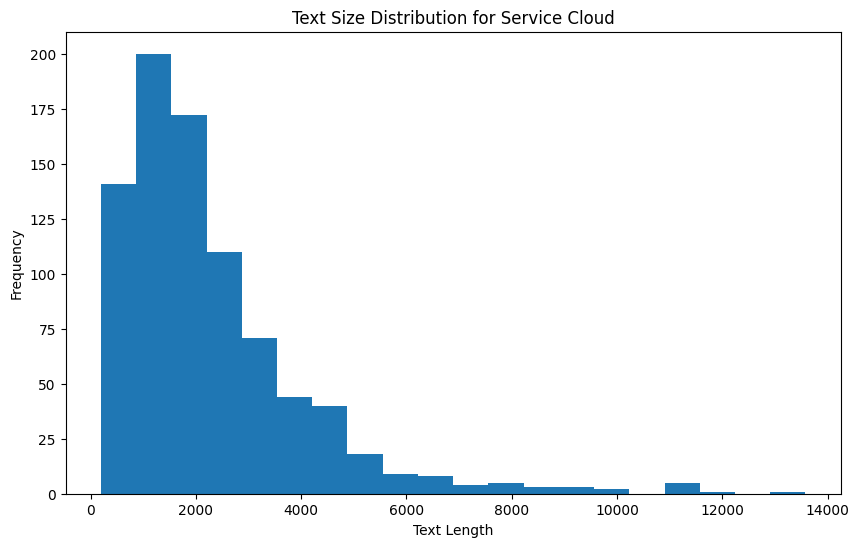

In [ ]:
# Print a histogram of the text length in each extracted file
create_text_length_histogram(df = service_merged_df, scope = "Service Cloud")

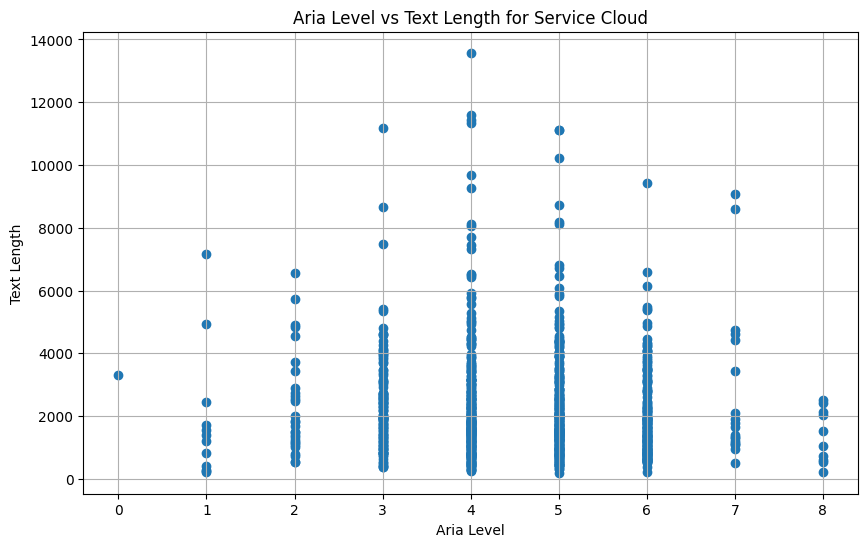

In [ ]:
# Print a plot of the text length in each file vs. the level of the hierarchy
create_level_to_length_plot(df = service_merged_df, scope = "Service Cloud")

# 4.&nbsp;Sales Cloud Scrape

## 4.1&nbsp; Estimate the Run Time

In [ ]:
print("Estimate Full Run Time =", round(((2 * 659) / 60),1), "mins")

Estimate Full Run Time = 22.0 mins


In [ ]:
print("Previous Processing Time to Complete:")
print("Run Date and Time: 2024-10-01 01:35:03")
print("Elapsed time: 6206.03s")
elap_sec = 6206.03
elap_min = elap_sec / 60
print("Elapsed time: ", round(elap_min,1), "mins")
elap_hr = elap_min / 60
print("Elapsed time: ", round(elap_hr,1), "hrs")

## 4.2&nbsp; Execute the Scrape

In [ ]:
# Run the process for Service Cloud
base_url = 'https://help.salesforce.com'
manifest_url = '/s/articleView?id=sf.sales_core.htm&type=5'

sales_merged_df = run_main(base_url, manifest_url, run_sample = False, sample_size = 5, run_spacer_time = 2, run_resize = False)


------------------------------------
Elapsed time: 0.00s
------------------------------------

URL: https://help.salesforce.com/s/articleView?id=sf.sales_core.htm&type=5
Manifest Scope: sales_core 

Extract of hierarchy completed:
depth of hierarchy = 7
number of records = 659

------------------------------------
Elapsed time: 8.54s
------------------------------------

Data In: 
href_url_list = 0      /s/articleView?id=sf.sales_core.htm&language=e...
1      /s/articleView?id=sf.sales_core_basics.htm&lan...
2      /s/articleView?id=sf.sales_core_seller_home.ht...
3      /s/articleView?id=sf.sales_core_record_labels....
4      /s/articleView?id=sf.sales_core_bring_in_leads...
                             ...                        
654    /s/articleView?id=sf.sc_linkedin_sales_navigat...
655    /s/articleView?id=sf.sc_linkedin_sales_navigat...
656    /s/articleView?id=sf.sc_linkedin_sales_navigat...
657    /s/articleView?id=sf.sc_linkedin_sales_navigat...
658    /s/articleView?id=sf.s

## 4.3&nbsp; Validate Output Data

In [ ]:
# Print a sample record from the extracted data
print("Sample of Sales Cloud Record Text:\n")
print(sales_merged_df.iloc[4]['url'],"\n")
print(textwrap.fill(sales_merged_df.iloc[4]['text'], width=100))

Sample of Sales Cloud Record Text:

https://help.salesforce.com/s/articleView?id=sf.sales_core_bring_in_leads.htm&language=en_US&type=5 

Capture ROI with Campaigns Organize and track your marketing efforts with Salesforce campaigns. When
you align your campaign structure to your business processes and strategies, you can report ongoing
marketing performance and ROI across activities and segments. Get to Know Salesforce Campaigns Many
cross-functional teams struggle to adequately communicate and hand off important data and resources.
Use Salesforce campaigns to bridge the gap between marketing and sales and promote your successes to
internal stakeholders. You can define campaign types, organize assets, add members, create campaign
hierarchies, and then track and report on campaign performance. Tools like Campaign Influence and
Einstein Attribution help attribute success and optimize future campaigns. Set Up Campaigns in
Salesforce Salesforce campaigns help you track engagement and repo

In [ ]:
# Print a sample of the extract table
print("Sample of Sales Cloud Table:\n")
display(sales_merged_df.head(3))

Sample of Sales Cloud Table:



,index,aria-level,title,id,href,parent,l0_id,l1_id,l2_id,l3_id,...,l0_title,l1_title,l2_title,l3_title,l4_title,l5_title,l6_title,l7_title,url,text
0,0,0,Sales Cloud Basics,sales_core_leaf,/s/articleView?id=sf.sales_core.htm&language=e...,None,sales_core_leaf,NaN,NaN,NaN,...,Sales Cloud Basics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Sales Cloud Basics The Sales Cloud provides ev...
1,1,1,"Learn About, Implement, and Optimize Sales Clo...",sales_core_basics_leaf,/s/articleView?id=sf.sales_core_basics.htm&lan...,sales_core_leaf,sales_core_leaf,sales_core_basics_leaf,NaN,NaN,...,Sales Cloud Basics,"Learn About, Implement, and Optimize Sales Clo...",NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,"Learn About, Implement, and Optimize Sales Clo..."
2,2,1,"See an Overview of Metrics, Goals, Suggestions...",sales_core_seller_home_leaf,/s/articleView?id=sf.sales_core_seller_home.ht...,sales_core_leaf,sales_core_leaf,sales_core_seller_home_leaf,NaN,NaN,...,Sales Cloud Basics,"See an Overview of Metrics, Goals, Suggestions...",NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,"See an Overview of Metrics, Goals, Suggestions..."
3,3,1,Organize and Find Records Easily with Personal...,sales_core_record_labels_leaf,/s/articleView?id=sf.sales_core_record_labels....,sales_core_leaf,sales_core_leaf,sales_core_record_labels_leaf,NaN,NaN,...,Sales Cloud Basics,Organize and Find Records Easily with Personal...,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Organize and Find Records Easily with Personal...
4,4,1,Capture ROI with Campaigns,sales_core_bring_in_leads_leaf,/s/articleView?id=sf.sales_core_bring_in_leads...,sales_core_leaf,sales_core_leaf,sales_core_bring_in_leads_leaf,NaN,NaN,...,Sales Cloud Basics,Capture ROI with Campaigns,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Capture ROI with Campaigns Organize and track ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,6278,3,Set Up LinkedIn Sales Navigator,sc_linkedin_sales_navigator_setup_leaf,/s/articleView?id=sf.sc_linkedin_sales_navigat...,sc_linkedin_sales_navigator_leaf,sales_core_leaf,sales_core_legacy_features_leaf,sc_linkedin_sales_navigator_leaf,sc_linkedin_sales_navigator_setup_leaf,...,Sales Cloud Basics,More Sales Features,Add LinkedIn Sales Navigator to Sales Cloud,Set Up LinkedIn Sales Navigator,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Set Up LinkedIn Sales Navigator To set up Link...
657,6279,4,Add LinkedIn Sales Navigator Components to Lea...,sc_linkedin_sales_navigator_setup_components_leaf,/s/articleView?id=sf.sc_linkedin_sales_navigat...,sc_linkedin_sales_navigator_setup_leaf,sales_core_leaf,sales_core_legacy_features_leaf,sc_linkedin_sales_navigator_leaf,sc_linkedin_sales_navigator_setup_leaf,...,Sales Cloud Basics,More Sales Features,Add LinkedIn Sales Navigator to Sales Cloud,Set Up LinkedIn Sales Navigator,Add LinkedIn Sales Navigator Components to Lea...,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Add LinkedIn Sales Navigator Components to Lea...
658,6280,4,Add LinkedIn Sales Navigator Lightning Actions...,sc_linkedin_sales_navigator_setup_actions_leaf,/s/articleView?id=sf.sc_linkedin_sales_navigat...,sc_linkedin_sales_navigator_setup_leaf,sales_core_leaf,sales_core_legacy_features_leaf,sc_linkedin_sales_navigator_leaf,sc_linkedin_sales_navigator_setup_leaf,...,Sales Cloud Basics,More Sales Features,Add LinkedIn Sales Navigator to Sales Cloud,Set Up LinkedIn Sales Navigator,Add LinkedIn Sales Navigator Lightning Actions...,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Add LinkedIn Sales Navigator Lightning Actions...
659,6283,3,Send LinkedIn InMail and Connection Requests f...,sc_linkedin_sales_navigator_send_inmail_and_cr...,/s/articleView?id=sf.sc_linkedin_sales_navigat...,sc_linkedin_sales_navigator_leaf,sales_core_lea

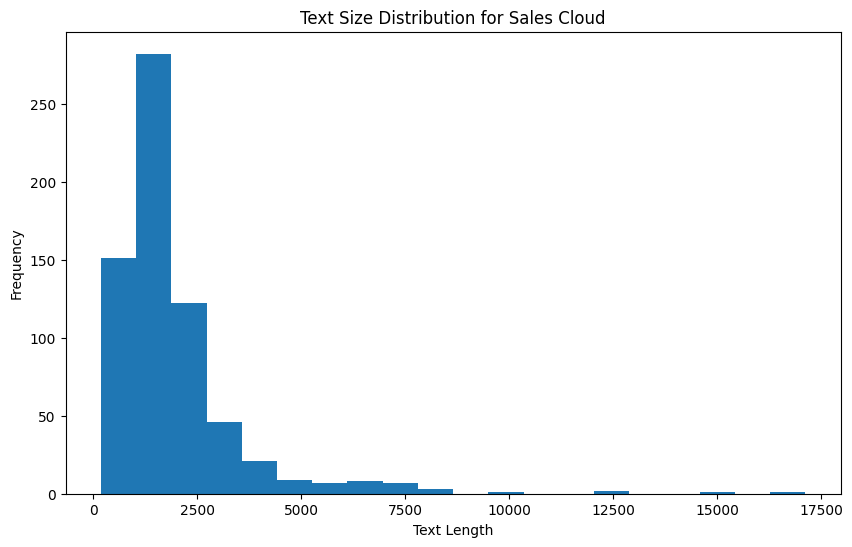

In [ ]:
# Print a histogram of the text length in each extracted file
create_text_length_histogram(df = sales_merged_df, scope = "Sales Cloud")

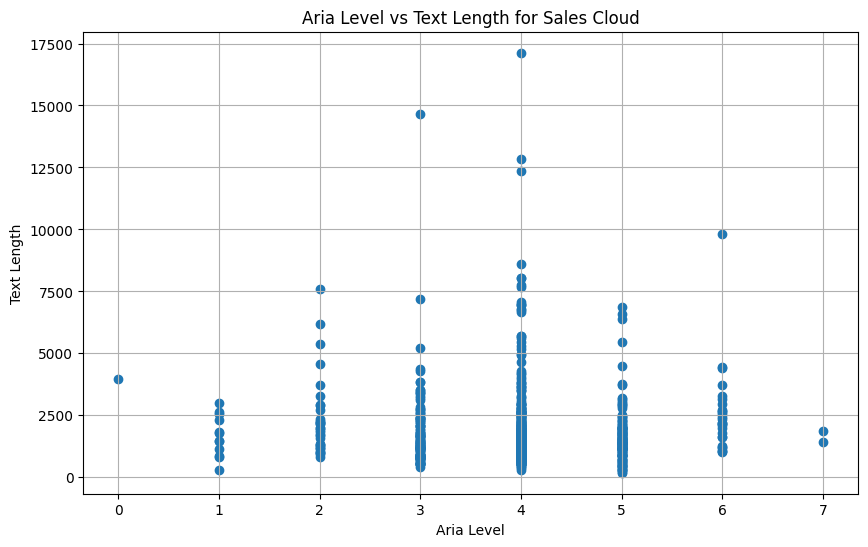

In [ ]:
# Print a plot of the text length in each file vs. the level of the hierarchy
create_level_to_length_plot(df = sales_merged_df, scope = "Sales Cloud")